# Getting started

In this tutorial, we will do parameter inference on a simple statistical model. 

First off, let's see whether `delfi` is installed properly:

In [1]:
import delfi
print(delfi.__version__)

0.1.3


No error was raised, and we can continue.

## Simulator

For the purpose of this example, we will consider a very simple statistical model, with a single parameter $\theta$. Depending on $\theta$, data is generated according to: $x|\mathbf{\theta} \sim 0.5 \mathcal{N}(x|\mu=\theta, \sigma^2=1) + 0.5 \mathcal{N}(x|\mu=\theta, \sigma^2=0.1)$

This model is implemented in `delfi.simulator`, we will import the model and create an instance:

In [2]:
from delfi.simulator import GaussMixture

n_params = 1
m = GaussMixture(dim=n_params)

## Prior

Next, we will define a prior distribution over $\theta$ as $\mathcal{U}(-10, 10)$:

In [3]:
import delfi.distribution as dd
import numpy as np

p = dd.Uniform(lower=[-10], upper=[10])

## Summary statistics

We will not reduce the dimensionality of our data, and instead just apply the identity:

In [4]:
from delfi.summarystats import Identity

s = Identity()

## Generator

Having defined the simulator, prior, and summary statistics, we instantiate a generator object:

In [5]:
from delfi.generator import Default

g = Default(model=m, prior=p, summary=s)

Having specified the generator, we can draw parameters and data using the `gen()` method:

In [6]:
params, stats = g.gen(250)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

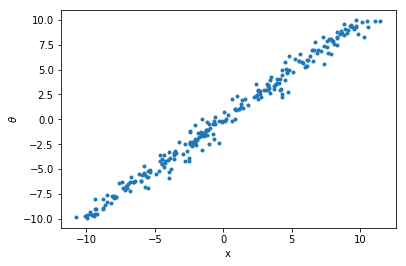

In [8]:
plt.plot(stats, params, '.')
plt.ylabel(r'$\theta$')
plt.xlabel(r'x');

## Inference

Say, we observed data $x_\text{o}$ and are interested in the posterior distribution $p(\theta|x=x_\text{o})$. The likelihood-free inference (LFI) algorithms implemented in `delfi` allow doing so, without using the likelihood function: In most real world application, the likelihood function is not available. We aim to do inference by just generating examples, i.e., simulating the model. 

We chose the toy model such that the posterior is easily tractable analytically. This will allow us to judge the result against the ground truth.

## Basic density estimation based LFI

A simple algorithm to use density estimation for LFI looks as follows:

![](../algorithms/basic.svg)

$q_\phi$ will be a mixture density network (MDN): The MDN is a neural network that maps from $x$ to a Gaussian mixture distribution. 

For our example, we will set $K=2$, such that the resulting mixtures will have two components.

To apply the above algorithm to the toy problem, create an instance of the inference algorithm specifying details:

In [9]:
from delfi.inference import Basic

inf_basic = Basic(generator=g, n_components=2, n_hiddens=[10])

We specified that we want K=2 components, and the neural network got a single hidden layer with 10 units. Additional entries in the list passed for `n_hiddens` would create additional layers.

In [10]:
log, train_data = inf_basic.run(n_train=5000)

We drew N=n_train training examples and ran the algorithm. We can plot the loss function, across training rounds of the neural network:

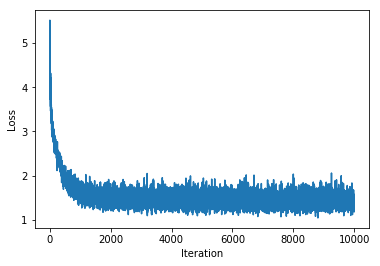

In [11]:
plt.plot(log['loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss');

Say we observed $x_o = 0.$ and want to predict the posterior $\hat{p}(\theta | x=x_{\text{o}})$:

In [12]:
xo = np.array([[0.]])
posterior = inf_basic.predict(xo)

The parameters of the predicted posterior are:

In [13]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))

component 1: mixture weight = 0.54; mean = -0.08; variance = 0.17
component 2: mixture weight = 0.46; mean = 0.12; variance = 1.03


The correct posterior for this problem is known -- since the prior is uniform it is simply: 

$$p(\theta|x=x_{\text{o}}) = 0.5 \mathcal{N}(\theta|\mu=0, \sigma^2=1) + 0.5 \mathcal{N}(\theta|\mu=0, \sigma^2=0.1)$$

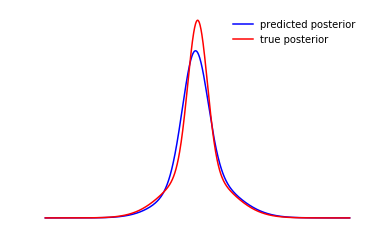

In [14]:
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## Sequential Neural Posterior Estimation

For the problem we picked here, the basic inference algorithm does a good job. More complicated problems, however, may require more sophisticated algorithms. 

Instead of sampling all parameters from the prior, we may draw only the first set of parameters from the prior and then switch to using a different distribution to sample from (a proposal distribution). Intuitively, the proposal distribution is chosen such that, when simulated, data is closer to $x_o$. In order to get the correct posterior, we will need to account for the fact that we drew these samples from a different distribution:

![](../algorithms/snpe.svg)

In [15]:
from delfi.inference import SNPE

xo = np.array([[0.]])
inf_snpe = SNPE(generator=g, n_components=2, n_hiddens=[10], obs=xo)
logs, tds = inf_snpe.run(n_train=[500, 4000], n_rounds=2)
posterior = inf_snpe.predict(xo)

component 1: mixture weight = 0.51; mean = 0.07; variance = 0.14
component 2: mixture weight = 0.49; mean = -0.11; variance = 0.97


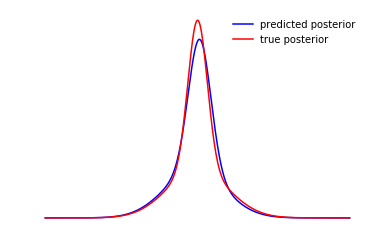

In [16]:
for k in range(2):
    print(r'component {}: mixture weight = {:.2f}; mean = {:.2f}; variance = {:.2f}'.format(
        k+1, posterior.a[k], posterior.xs[k].m[0], posterior.xs[k].S[0][0]))
    
true_posterior = dd.MoG(a=[0.5, 0.5], ms=[[0.], [0.]], Ss=[[[1.0]], [[0.1]]])
plt.plot(posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-b')
plt.plot(true_posterior.eval(np.arange(-5.0, 5.0, 0.01).reshape(-1,1), log=False), '-r')
plt.legend(['predicted posterior', 'true posterior'], frameon=False)
plt.axis('off');

## Conditional density estimation LFI

Finally, `delfi` implements an algorithm by Papamakarios and Murray (2016) which inspired SNPE. For details see:
[Fast ε-free Inference of Simulation Models with Bayesian Conditional Density Estimation](https://arxiv.org/abs/1605.06376v3). Similar to `Basic` and `SNPE`, `CDELFI` can be imported from `delfi.inference`.

## Adapting to other problems

In order to use `delfi` with a specific problem, you'd need to implement a simulator class and possibly summary statistics.

Simulators should inherit from a simulator base class. The base class for simulators specifies that each child needs to inherit a method called `gen_single()` -- the function that forward simulates a single $\theta$ to data. It should return a dictionary that contains the result under a key called `data`. [This is also detailled in the docstring of the base class](https://github.com/mackelab/delfi/blob/master/delfi/simulator/BaseSimulator.py). For an actual implementation, you can see the code for the mixture model we used above: https://github.com/mackelab/delfi/blob/master/delfi/simulator/GaussMixture.py.

For this example, we used the identity as a summary statistics. If you were to use summary statistics, consider the implementation of mean summary statistics for a basic example: https://github.com/mackelab/delfi/blob/master/delfi/summarystats/Mean.py, and again, there is a [base class specifying the interface](https://github.com/mackelab/delfi/blob/master/delfi/summarystats/BaseSummaryStats.py).